# Sparkify - use Spark and ML to predict churn

Author: Heng Li

## Objective

Sparkify is a music streaming serivce similar to Apple Music, Spotify,etc. The dataset provided is in the form of event logs when customers use the streaming services, including artists, songs, geolocation, timestamp, demographic infos, user actions etc. 

The main goal of this project is to analyze the event log and build a machine learning model to predict the users who are more likely to cancel service (churn), and thus use this information in ad compaign to reduce customer out-flow.

In addition, due to the amount of data used, we leveraged spark (pySpark), spark SQL, spark ML and cloud service provided by [IBM](https://cloud.ibm.com/) to perform data wrangling, exploration, and machine learning tasks.


In [ ]:
# this code snippets are auto generated by IBM when creating pySpark project in Watson Studio

import ibmos2spark, os
# @hidden_cell

credentials = {
    'endpoint': 'your_endpoint_url',
    'service_id': 'your_iam-ServiceId',
    'iam_service_endpoint': 'your_token',
    'api_key': 'your_api_key'
}

configuration_name = 'os_your_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

## Import utility libraries

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.linalg import DenseVector

In [3]:
# check seaborn version
sns.__version__
# ! pip install seaborn==0.11.2

'0.11.2'

## Load and clean dataset

Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
event_log = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-f51jkpiohqqwtx'))
event_log.createOrReplaceTempView("event_log")
event_log.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [5]:
event_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# check total number of records
spark.sql("SELECT COUNT(*) FROM event_log").show()

+--------+
|count(1)|
+--------+
|  543705|
+--------+



In [7]:
# check if any userId is empty or null
spark.sql("SELECT COUNT(userId) AS userId_empty_count FROM event_log WHERE userId = ''").show()
spark.sql("SELECT COUNT(userId) AS userId_null_count FROM event_log WHERE userId IS NULL").show()

+------------------+
|userId_empty_count|
+------------------+
|             15700|
+------------------+

+-----------------+
|userId_null_count|
+-----------------+
|                0|
+-----------------+



In [8]:
# check what type of auth corresponding to empty userId
spark.sql("SELECT DISTINCT auth FROM event_log WHERE userId = ''").show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



**NOTE**: Empty userId either comes from Logged Out or Guest Users. No null userId found.

In [9]:
# check if any sessionId is empty or null
spark.sql("SELECT COUNT(sessionId) AS sessionId_empty_count FROM event_log WHERE sessionId = ''").show()
spark.sql("SELECT COUNT(sessionId) AS sessionId_null_count FROM event_log WHERE sessionId IS NULL").show()

+---------------------+
|sessionId_empty_count|
+---------------------+
|                    0|
+---------------------+

+--------------------+
|sessionId_null_count|
+--------------------+
|                   0|
+--------------------+



**NOTE**: No empty nor null sessionId found.

In [10]:
# select rows with non-empty userId, and store in a DataFrame called event_log_clean. Create view
event_log_clean = spark.sql("SELECT * FROM event_log WHERE userId <> ''")
event_log_clean.createOrReplaceTempView("event_log_clean")

## Exploratory Data Analysis

### Define Churn

In order to define churn, let's first take a look at different user event

In [11]:
# extract the page and find the events. Use Cancellation Confirmation event as the churn, set the corresponding Churn column to be 1, else 0
pages = spark.sql("SELECT DISTINCT page FROM event_log_clean")
page_events = [row['page'] for row in pages.collect()]
page_events

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

Looking at the page events, **we define `churn` when user has page `Cancellation Confirmation` page event**. To assign `churn` to appropriate `userId`, we first define the occurance of `churn_event` when `Cancellation Confirmation` occured.

In [12]:
# assign churn_event
event_log_churn = spark.sql("""
    SELECT
        ec.*,
        FROM_UNIXTIME(registration/1000, "Y-M-d HH:mm:ss") AS registration_time,
        FROM_UNIXTIME(ts/1000, "Y-M-d HH:mm:ss") AS action_time,
        CASE
            WHEN ec.page='Cancellation Confirmation' THEN 1
            ELSE 0
        END AS churn_event
    FROM
        event_log_clean AS ec
""")

event_log_churn.createOrReplaceTempView("event_log_churn")

In [13]:
# keep columns other than firstName, LastName, ts. Add churn columns with binary value of 0: not churned and 1: churned for users with churn_event = 1
event_log_churn = spark.sql("""
    SELECT
        artist,auth,gender,itemInSession,
        length,level,location,method,page,
        registration_time,sessionId,song,status,
        userAgent,userId,action_time,churn_event,
        MAX(churn_event) OVER (PARTITION BY userId) AS churn
    FROM
        event_log_churn
""")

event_log_churn.createOrReplaceTempView("event_log_churn")

Test to check if `churn` assignment works as expected.

In [14]:
# select userId that churned
spark.sql("""
    SELECT action_time, page, userId, level, churn_event,churn 
    FROM event_log_churn
    WHERE churn = 1 and churn_event = 1 
    ORDER BY userId, action_time
    LIMIT 10
""").show()

+-------------------+--------------------+------+-----+-----------+-----+
|        action_time|                page|userId|level|churn_event|churn|
+-------------------+--------------------+------+-----+-----------+-----+
| 2018-10-9 03:22:44|Cancellation Conf...|    10| paid|          1|    1|
| 2018-10-2 14:50:59|Cancellation Conf...|100001| free|          1|    1|
| 2018-11-8 07:19:52|Cancellation Conf...|100003| paid|          1|    1|
|2018-10-14 10:13:00|Cancellation Conf...|100004| free|          1|    1|
| 2018-10-6 10:11:19|Cancellation Conf...|100005| free|          1|    1|
|2018-10-11 10:38:38|Cancellation Conf...|100010| free|          1|    1|
|2018-11-21 22:35:33|Cancellation Conf...|100011| paid|          1|    1|
| 2018-11-6 14:35:50|Cancellation Conf...|100012| free|          1|    1|
| 2018-10-2 19:13:11|Cancellation Conf...|100013| free|          1|    1|
|2018-10-21 06:37:37|Cancellation Conf...|100014| paid|          1|    1|
+-------------------+-----------------

In [15]:
# check if churn labeling is correctly implemented for userId 100001
spark.sql("""
    SELECT action_time, page, userId, level, churn_event,churn 
    FROM event_log_churn
    WHERE userId = 100001 
    ORDER BY action_time DESC
    LIMIT 10
""").show()

+------------------+--------------------+------+-----+-----------+-----+
|       action_time|                page|userId|level|churn_event|churn|
+------------------+--------------------+------+-----+-----------+-----+
|2018-10-2 14:50:59|Cancellation Conf...|100001| free|          1|    1|
|2018-10-2 14:50:20|              Cancel|100001| free|          0|    1|
|2018-10-2 14:50:19|         Roll Advert|100001| free|          0|    1|
|2018-10-2 14:50:14|            NextSong|100001| free|          0|    1|
|2018-10-2 14:47:45|            NextSong|100001| free|          0|    1|
|2018-10-2 14:43:57|            NextSong|100001| free|          0|    1|
|2018-10-2 14:40:24|            NextSong|100001| free|          0|    1|
|2018-10-2 14:40:02|         Roll Advert|100001| free|          0|    1|
|2018-10-2 14:32:14|            NextSong|100001| free|          0|    1|
|2018-10-2 14:27:16|            NextSong|100001| free|          0|    1|
+------------------+--------------------+------+---

### Explore Data
Exploratory data analysis to observe the overall state of business and behavior for users who stayed vs users who churned.

In [16]:
# prepare to get monthly active users, and service usage

spark.sql("SELECT MIN(action_time) AS begin, MAX(action_time) AS end FROM event_log_churn").show()

+------------------+------------------+
|             begin|               end|
+------------------+------------------+
|2018-10-1 00:00:11|2018-12-1 00:01:06|
+------------------+------------------+



**NOTE**: Two months of data.

Let's take a look at some user behavior during the two-month period.

In [17]:
spark.sql("""
    SELECT
        userId,
        level,
        SUM(CASE WHEN DATE_FORMAT(action_time, "Y-M" ) = "2018-10" THEN 1 ELSE 0 END) AS `2018-10`,
        SUM(CASE WHEN DATE_FORMAT(action_time, "Y-M" ) = "2018-11" THEN 1 ELSE 0 END) AS `2018-11`
    FROM
        event_log_churn
    GROUP BY
        userId, level
    LIMIT 20
""").show()

+------+-----+-------+-------+
|userId|level|2018-10|2018-11|
+------+-----+-------+-------+
|    18| free|    319|      0|
|200050| paid|    367|    251|
|   185| free|     51|      0|
|200021| free|    507|      0|
|   207| free|    108|      0|
|     6| free|    678|     35|
|   190| paid|    837|     58|
|   227| free|    157|     36|
|   289| paid|      9|    630|
|300022| paid|    449|    373|
|   132| free|     76|      0|
|   112| free|    222|    189|
|   168| paid|    268|    845|
|100035| paid|    416|    278|
|   184| paid|    694|    839|
|    16| paid|    559|     39|
|200007| paid|     77|     40|
|300015| free|     57|      0|
|    39| free|    537|      0|
|300014| paid|    110|    195|
+------+-----+-------+-------+



In [18]:
# Monthly active users
spark.sql("""
    SELECT
        DATE_FORMAT(action_time, "Y-M") AS month,
        COUNT(DISTINCT userId) as active_users
    FROM
        event_log_churn
    GROUP BY
        DATE_FORMAT(action_time, "Y-M")
""").show()

+-------+------------+
|  month|active_users|
+-------+------------+
|2018-10|         430|
|2018-11|         383|
|2018-12|           4|
+-------+------------+



**NOTE**: Some users increase service usage from Oct to Nov; Some decrease or even not use the service at all. The aggregated effect is that there is drop in monthly active users from Oct to Nov. **Therefore, it is necessary to find the users based on user behaviors to decrease churn rate.**

Let's explore the users who churned vs not churned.

In [19]:
# total number of churned vs not churned userId
spark.sql("SELECT churn, COUNT(DISTINCT userId) AS num_userId FROM event_log_churn GROUP BY churn").show()

+-----+----------+
|churn|num_userId|
+-----+----------+
|    1|        99|
|    0|       349|
+-----+----------+



**NOTE**: The churned proportion among all distinct users is 0.2210 or 22.10%.

#### Categorical columns
Let's take a look at break-down by categorical columns, such as gender and level (paid vs free).

In [20]:
# churn break down by gender
spark.sql("SELECT churn, gender, COUNT(DISTINCT userId) AS num_userId FROM event_log_churn GROUP BY churn, gender ORDER BY churn, gender").show()

+-----+------+----------+
|churn|gender|num_userId|
+-----+------+----------+
|    0|     F|       153|
|    0|     M|       196|
|    1|     F|        45|
|    1|     M|        54|
+-----+------+----------+



Hypothesis testing to check if the difference in proportion is significant, use $\alpha$ = 0.05 as the significance level:

$$
\begin{align}
H_0: p_{female} - p_{male} = 0 \\
H_a: p_{female} - p_{male} \neq 0
\end{align}
$$

In [21]:
proportions_ztest([45,54],[198,250],0, 'two-sided')

(0.28558822400048295, 0.7751935238693246)

p_value is greater than 0.05, we failed to reject the null hypothesis. **Even though female users have slightly higher churn propotion than male users ($p_{female}$=0.2273 vs $p_{male}$=0.2160), the difference in churned proportion between female and male users is not significant**.

In [22]:
# churn break down by free and paid level
spark.sql("SELECT churn, level, COUNT(DISTINCT userId) AS num_userId FROM event_log_churn GROUP BY churn, level ORDER BY churn, level").show()

+-----+-----+----------+
|churn|level|num_userId|
+-----+-----+----------+
|    0| free|       288|
|    0| paid|       246|
|    1| free|        82|
|    1| paid|        75|
+-----+-----+----------+



Hypothesis testing to check if the difference in proportion is significant, use $\alpha$ = 0.05 as the significance level:

$$
\begin{align}
H_0: p_{paid} - p_{free} = 0 \\
H_a: p_{paid} - p_{free} \neq 0
\end{align}
$$

In [23]:
proportions_ztest([75,82],[321,370],0, 'two-sided')

(0.3761780043645429, 0.7067845664894525)

p_value is greater than 0.05, we failed to reject the null hypothesis. Even though free users have slightly lower churn propotion than paid users ($p_{free}$=0.2216 vs $p_{paid}$=0.2336), the difference in churn proportion between free and paid users is not significant.

**NOTE:**
The total number of distinct userId under free and paid level (691) exceed the overall unique userId's (448). This is because, some users 'Upgrade' to paid level or 'Downgrade' to free level, resulting duplicated counting.

In [24]:
# check userId's who have Downgrade and Upgrade events
spark.sql("""
    SELECT page as action, COUNT(DISTINCT userId) AS num_userId 
    FROM event_log_churn WHERE page in ('Downgrade','Upgrade') GROUP BY page ORDER BY page
""").show()

+---------+----------+
|   action|num_userId|
+---------+----------+
|Downgrade|       301|
|  Upgrade|       315|
+---------+----------+



#### Numerical columns

In [25]:
event_log_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- action_time: string (nullable = true)
 |-- churn_event: integer (nullable = false)
 |-- churn: integer (nullable = true)



In [26]:
# convert registration_time till churn_event occurs to tenure_days
# calculate customer tenure in days
users_tenure = spark.sql("""
    SELECT userId, 
    INT((UNIX_TIMESTAMP(MAX(action_time)) - UNIX_TIMESTAMP(MIN(registration_time)))/86400) AS tenure_days,
    MAX(churn) AS churn
    FROM event_log_churn
    GROUP BY userId
""")
users_tenure.createOrReplaceTempView("users_tenure")
users_tenure.show(5)

+------+-----------+-----+
|userId|tenure_days|churn|
+------+-----------+-----+
|100010|         11|    1|
|200002|         32|    1|
|   296|         25|    1|
|   125|        105|    0|
|   124|        109|    1|
+------+-----------+-----+
only showing top 5 rows



In [27]:
# dataframe to store users_actions
users_actions = spark.sql("""
    SELECT DISTINCT ec.userId,
    ec.churn,
    ec.level,
    ec.gender,
    ut.tenure_days,
    COUNT(DISTINCT ec.sessionId) AS total_session,
    SUM(CASE WHEN ec.page='Thumbs Down' THEN 1 ELSE 0 END) AS total_thumbs_down,
    SUM(CASE WHEN ec.page='Home' THEN 1 ELSE 0 END) AS total_home,
    SUM(CASE WHEN ec.page='Roll Advert' THEN 1 ELSE 0 END) AS total_roll_advert,
    SUM(CASE WHEN ec.page='Logout' THEN 1 ELSE 0 END) AS total_logout,
    SUM(CASE WHEN ec.page='Save Settings' THEN 1 ELSE 0 END) AS total_save_settings,
    SUM(CASE WHEN ec.page='About' THEN 1 ELSE 0 END) AS total_about,
    SUM(CASE WHEN ec.page='Settings' THEN 1 ELSE 0 END) AS total_settings,
    SUM(CASE WHEN ec.page='Add to Playlist' THEN 1 ELSE 0 END) AS total_add_to_playlist,
    SUM(CASE WHEN ec.page='Add Friend' THEN 1 ELSE 0 END) AS total_add_friend,
    SUM(CASE WHEN ec.page='NextSong' THEN 1 ELSE 0 END) AS total_nextsong,
    SUM(CASE WHEN ec.page='Thumbs Up' THEN 1 ELSE 0 END) AS total_thumbs_up,
    SUM(CASE WHEN ec.page='Help' THEN 1 ELSE 0 END) AS total_help,
    SUM(CASE WHEN ec.page='Error' THEN 1 ELSE 0 END) AS total_error
    FROM event_log_churn ec
            JOIN
         users_tenure ut ON ut.userId = ec.userId
    GROUP BY ec.userId, ec.churn, ec.level, ec.gender, ut.tenure_days
""")

In [28]:
users_actions_df=users_actions.toPandas()

In [29]:
users_actions_df.head(10)

,userId,churn,level,gender,tenure_days,total_session,total_thumbs_down,total_home,total_roll_advert,total_logout,total_save_settings,total_about,total_settings,total_add_to_playlist,total_add_friend,total_nextsong,total_thumbs_up,total_help,total_error
0,100010,1,free,F,11,2,3,3,22,1,0,0,0,1,3,96,4,0,0
1,200002,1,free,M,32,4,2,12,11,6,0,1,0,4,2,167,7,1,0
2,200002,1,paid,M,32,2,3,11,0,5,0,0,2,2,0,143,8,0,0
3,296,1,free,F,25,3,0,4,9,2,0,0,1,2,2,76,6,1,0
4,296,1,paid,F,25,3,0,3,0,1,0,0,0,1,0,36,2,1,0
5,125,0,free,M,105,3,1,2,6,0,0,0,3,2,3,62,3,2,0
6,124,1,paid,F,109,17,15,70,1,17,3,3,15,45,26,1826,102,10,0
7,51,1,paid,M,8,5,1,17,1,6,0,0,2,8,3,266,16,0,2
8,7,0,free,M,59,15,4,36,35,11,2,2,5,6,16,462,12,3,0
9,200037,1,free,M,27,7,3,6,9,0,0,1,1,4,2,122,5,0,0


In [30]:
users_actions_df.shape

(691, 19)

**NOTE**: Again, there are multiple users who have been both paid and free users due to upgrade and downgrade events. 

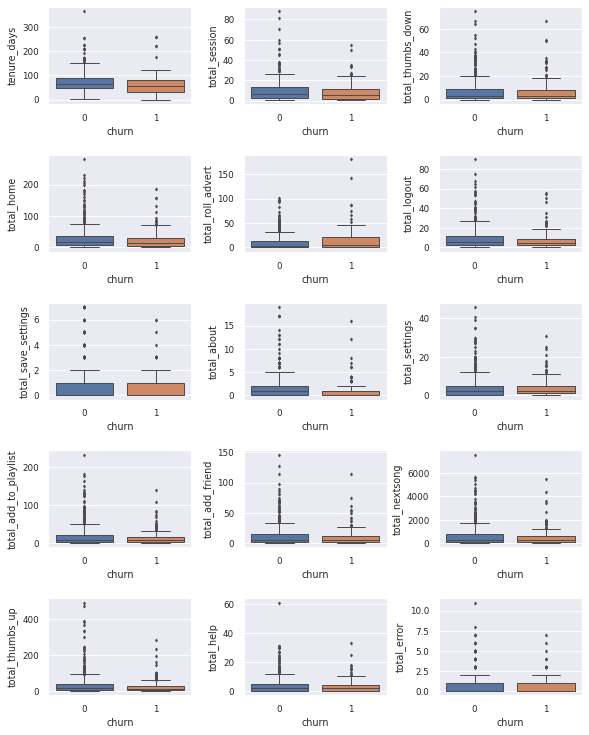

In [31]:
# churn break down by numerical columns
names=['tenure_days', 'total_session',
       'total_thumbs_down', 'total_home', 'total_roll_advert', 'total_logout',
       'total_save_settings', 'total_about', 'total_settings',
       'total_add_to_playlist', 'total_add_friend', 'total_nextsong',
       'total_thumbs_up', 'total_help', 'total_error']

sns.set(rc={'figure.figsize':(8,10)})
sns.set(font_scale=0.8)
fig, axes = plt.subplots(5, 3);
fig.tight_layout(pad=0.5, w_pad=2, h_pad=3);

for i in range(5):
    for j in range(3):
        sns.boxplot(x="churn", y=names[i*3+j], data=users_actions_df, linewidth=1, fliersize=2,ax=axes[i][j]);

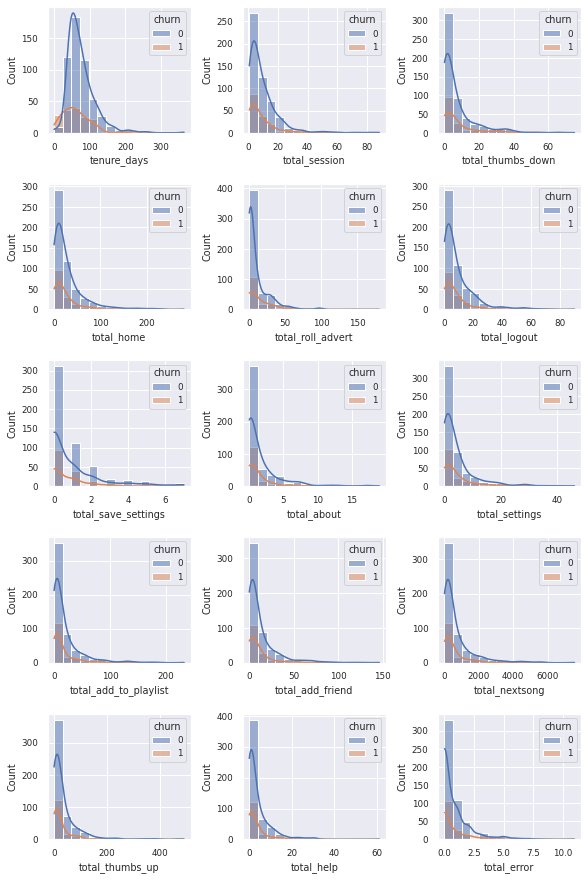

In [32]:
names=['tenure_days', 'total_session',
       'total_thumbs_down', 'total_home', 'total_roll_advert', 'total_logout',
       'total_save_settings', 'total_about', 'total_settings',
       'total_add_to_playlist', 'total_add_friend', 'total_nextsong',
       'total_thumbs_up', 'total_help', 'total_error']

sns.set(rc={'figure.figsize':(8,12)})
sns.set(font_scale=0.8)
fig, axes = plt.subplots(5, 3);
fig.tight_layout(pad=0.5, w_pad=2, h_pad=3);

for i in range(5):
    for j in range(3):
        sns.histplot(data=users_actions_df[['churn',names[i*3+j]]], x=names[i*3+j], bins=15, hue="churn", kde=True, edgecolor='w', linewidth=1, ax=axes[i][j]);

**NOTE**: In general, unchurned users interacts more with the service across all events compared with churned users. Due to nature of aggregated properties and potential correlation between page actions, it is needed to explore on the correlations among the actions.

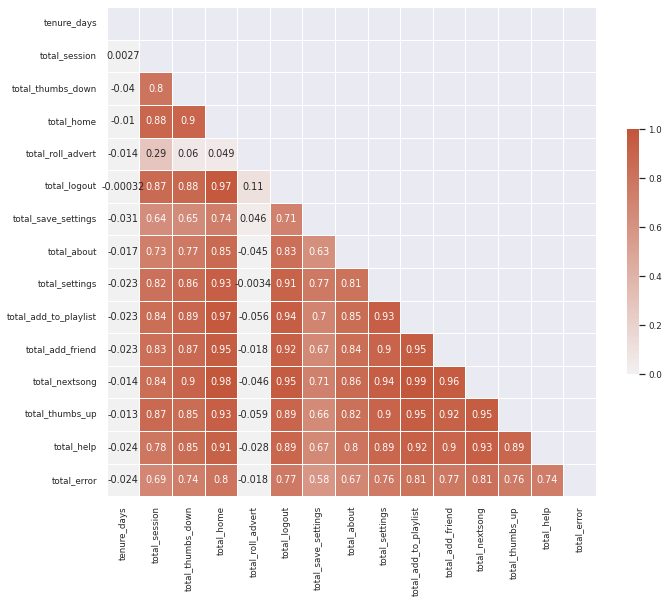

In [33]:
# Compute the correlation matrix
corr = users_actions_df.iloc[:,4:19].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmin= 0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**NOTE**: Strong correlations among a lot of user actions! Proper feature engineering is needed to reduce correlations.

## Feature Engineering


In [34]:
# normalize the events by session for each individual user
users_actions_df['thumbs_down_per_session'] = users_actions_df['total_thumbs_down'] / users_actions_df['total_session']
users_actions_df['home_per_session'] = users_actions_df['total_home'] / users_actions_df['total_session']
users_actions_df['roll_advert_per_session'] = users_actions_df['total_roll_advert'] / users_actions_df['total_session']
users_actions_df['save_settings_per_session'] = users_actions_df['total_save_settings'] / users_actions_df['total_session']
users_actions_df['about_per_session'] = users_actions_df['total_about'] / users_actions_df['total_session']
users_actions_df['settings_per_session'] = users_actions_df['total_settings'] / users_actions_df['total_session']
users_actions_df['add_to_playlist_per_session'] = users_actions_df['total_add_to_playlist'] / users_actions_df['total_session']
users_actions_df['add_friend_per_session'] = users_actions_df['total_add_friend'] / users_actions_df['total_session']
users_actions_df['nextsong_per_session'] = users_actions_df['total_nextsong'] / users_actions_df['total_session']
users_actions_df['thumbs_up_per_session'] = users_actions_df['total_thumbs_up'] / users_actions_df['total_session']
users_actions_df['help_per_session'] = users_actions_df['total_help'] / users_actions_df['total_session']
users_actions_df['error_per_session'] = users_actions_df['total_error'] / users_actions_df['total_session']

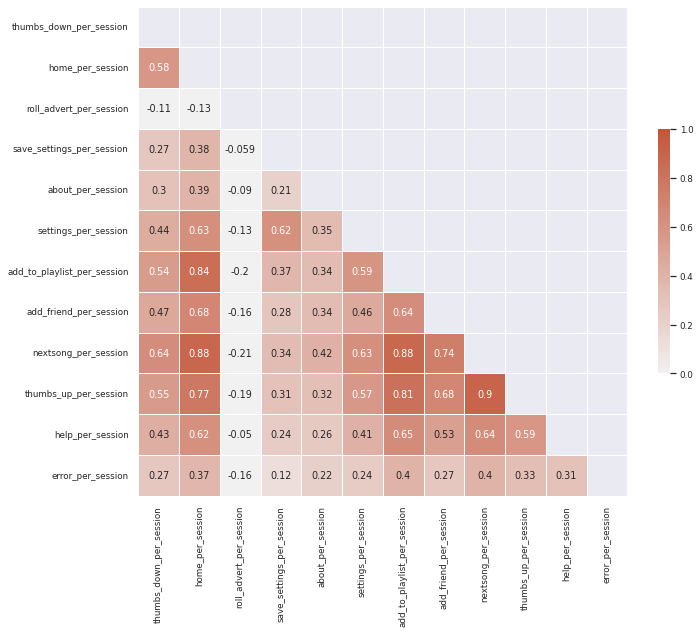

In [35]:
# Compute the correlation matrix
corr = users_actions_df.iloc[:,19:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmin= 0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**NOTE**: Some features are still highly correlated, such as add_to_playlist_per_session, home_per_session, thums_up_per_session, and next_song_per_session. These are all related to events implying positive user experience. Add those feature together into a new feature, named postive_engagement_per_session.

In [36]:
users_actions_df['positive_engagement_per_session'] = users_actions_df['thumbs_up_per_session'] + users_actions_df['home_per_session']+users_actions_df['add_to_playlist_per_session']+ users_actions_df['nextsong_per_session']

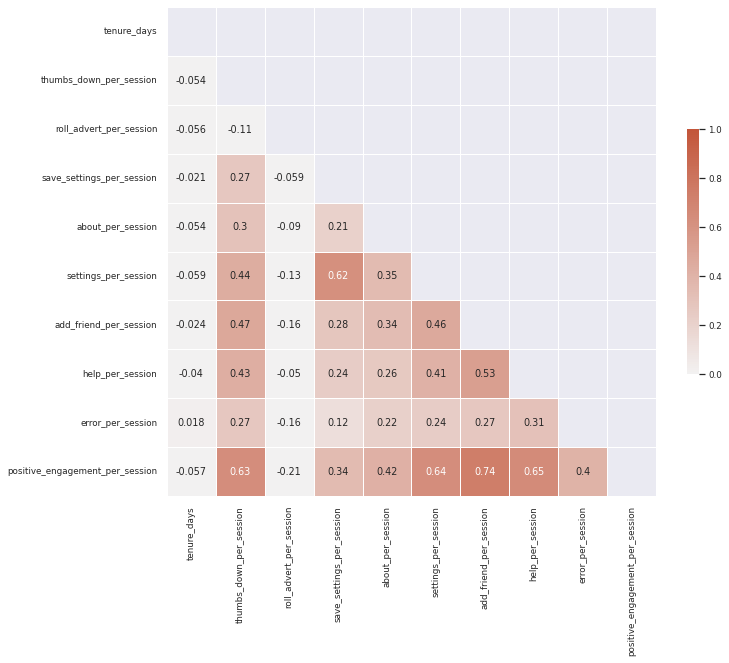

In [37]:
# check correlation for 4,19,21,22,23,24,26,29,30,31

# Compute the correlation matrix
corr = users_actions_df.iloc[:,[4,19,21,22,23,24,26,29,30,31]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmin= 0, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### Save dataframe after feature engineering

In [38]:
engineered_df = users_actions_df.iloc[:,[0,1,2,3,4,19,21,22,23,24,26,29,30,31]]
file_path = 'engineered_dataset.csv'
engineered_df.to_csv(file_path)

## Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine the winning model based on test accuracy and report results on the test set. Since the churned users are a fairly small subset, F1 score will be used as the metric to optimize.

In [39]:
df = spark.read.load("engineered_dataset.csv",
                     format="csv", sep=",", inferSchema="true", header="true")
df.show(1)

+---+------+-----+-----+------+-----------+-----------------------+-----------------------+-------------------------+-----------------+--------------------+----------------------+----------------+-----------------+-------------------------------+
|_c0|userId|churn|level|gender|tenure_days|thumbs_down_per_session|roll_advert_per_session|save_settings_per_session|about_per_session|settings_per_session|add_friend_per_session|help_per_session|error_per_session|positive_engagement_per_session|
+---+------+-----+-----+------+-----------+-----------------------+-----------------------+-------------------------+-----------------+--------------------+----------------------+----------------+-----------------+-------------------------------+
|  0|100010|    1| free|     F|         11|                    1.5|                   11.0|                      0.0|              0.0|                 0.0|                   1.5|             0.0|              0.0|                           52.0|
+---+------+

In [40]:
# label encode catergorical columns: gender and level

from pyspark.ml.feature import StringIndexer

genderIndexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
df = genderIndexer.fit(df).transform(df)
levelIndexer = StringIndexer(inputCol="level", outputCol="levelIndex")
df = levelIndexer.fit(df).transform(df)

# remove _c0, userId, original gender and level column column
columns_to_drop=['userId', '_c0', 'gender','level']
df = df.drop(*columns_to_drop)
feature_cols = df.columns
feature_cols.remove('churn')
# split data into training and test set
train_set, test_set = df.randomSplit([4.0,1.0])

In [41]:
# further split data into training and validation
training, validation = train_set.randomSplit([4.0,1.0])

### Baseline performance using default settings from Spark ML

In [44]:
# prep for build pipline
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
evaluator = MulticlassClassificationEvaluator(labelCol='churn')
baseline_scores = []

#### Logisitc regression classifier

In [45]:
lrc = LogisticRegression(featuresCol='features_scaled', labelCol='churn')
lrc_pipeline = Pipeline(stages=[assembler, scaler, lrc])
lrc_model = lrc_pipeline.fit(training)
preditions = lrc_model.transform(validation)
baseline_scores.append(['logistic_regression', evaluator.setMetricName('f1').evaluate(preditions), evaluator.setMetricName('accuracy').evaluate(preditions)])

#### Decision tree classifier

In [46]:
dtc = DecisionTreeClassifier(featuresCol='features_scaled', labelCol='churn')
dtc_pipeline = Pipeline(stages=[assembler, scaler, dtc])
dtc_model = dtc_pipeline.fit(training)
preditions = dtc_model.transform(validation)
baseline_scores.append(['decision_tree', evaluator.setMetricName('f1').evaluate(preditions), evaluator.setMetricName('accuracy').evaluate(preditions)])

#### Random forest classifier

In [47]:
rfc = RandomForestClassifier(featuresCol='features_scaled', labelCol='churn')
rfc_pipeline = Pipeline(stages=[assembler, scaler, rfc])
rfc_model = rfc_pipeline.fit(training)
preditions = rfc_model.transform(validation)
baseline_scores.append(['random_forest', evaluator.setMetricName('f1').evaluate(preditions), evaluator.setMetricName('accuracy').evaluate(preditions)])

#### Gradient boost tree classifier

In [48]:
gbtc = GBTClassifier(featuresCol='features_scaled', labelCol='churn')
gbtc_pipeline = Pipeline(stages=[assembler, scaler, gbtc])
gbtc_model = gbtc_pipeline.fit(training)
preditions = gbtc_model.transform(validation)
baseline_scores.append(['gradient_boost_tree', evaluator.setMetricName('f1').evaluate(preditions), evaluator.setMetricName('accuracy').evaluate(preditions)])

#### Baseline performance

In [49]:
baseline_scores_df = pd.DataFrame(baseline_scores, columns=['classifier', 'f1', 'accuracy'])
baseline_scores_df

,classifier,f1,accuracy
0,logistic_regression,0.752193,0.806723
1,decision_tree,0.715601,0.722689
2,random_forest,0.776087,0.815126
3,gradient_boost_tree,0.758226,0.781513


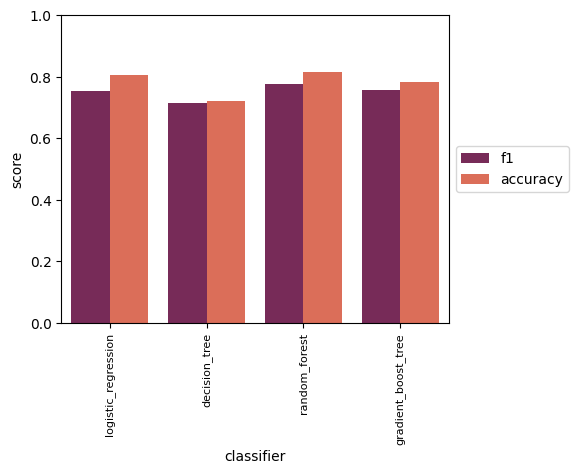

In [50]:
# visualize
baseline_scores_sns = pd.melt(baseline_scores_df, id_vars="classifier", var_name="metric", value_name="score")
sns.reset_orig()

fig = plt.figure(figsize=(5, 4))
sns.barplot(x='classifier', y='score', hue='metric', palette='rocket',data=baseline_scores_sns);
plt.ylim(0,1);
plt.xticks(rotation=90,fontsize=8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

**NOTE**: From the baseline score result, random forest classifier has the highest f1 score and accuracy.

In [1]:
print('baseline random forest classifier params: ')
print('numTrees = {}  maxDepth = {}  maxBins = {}'.format(rfc._java_obj.getNumTrees(), rfc._java_obj.getMaxDepth(), rfc._java_obj.getMaxBins()))

baseline random forest classifier params: 
numTrees = 20  maxDepth = 5  maxBins = 32


In [52]:
# use baseline random forest classifier to evaluate test set
preditions = rfc_model.transform(test_set)
f1_score = evaluator.setMetricName('f1').evaluate(preditions)
accuracy = evaluator.setMetricName('accuracy').evaluate(preditions)
print('baseline random forest classifier performance:')
print('f-1 score: ', f1_score)
print('accuracy: ', accuracy)

baseline random forest classifier performance:
f-1 score:  0.7007142857142856
accuracy:  0.76


### Hyperparameter tuning

In [65]:
# hyperparameter tuning

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
evaluator = MulticlassClassificationEvaluator(labelCol='churn')


rfc = RandomForestClassifier(featuresCol='features_scaled', labelCol='churn')
rfc_pipeline = Pipeline(stages=[assembler, scaler, rfc])


paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [10, 20, 30, 40]) \
    .addGrid(rfc.maxDepth, [3, 5, 7, 9]) \
    .addGrid(rfc.maxBins, [24, 32, 40, 48]) \
    .build()

crossval = CrossValidator(estimator=rfc_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator.setMetricName('f1'),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_set)

In [66]:
# take a look at cv results
cvModel.avgMetrics

[0.748121951457225,
 0.7534474611974544,
 0.7747021315387778,
 0.7635933859796292,
 0.7604576688128311,
 0.7596447191653904,
 0.7620261569946092,
 0.7651930480782112,
 0.7571676503210361,
 0.7616862170344698,
 0.7605301668739999,
 0.7727112377552012,
 0.7474080583560858,
 0.7487325711164905,
 0.7702121271962459,
 0.7556594178602094,
 0.756198198370432,
 0.7619017650364605,
 0.7600760560369515,
 0.7597374814129324,
 0.761380117153786,
 0.7599490783904422,
 0.7731734411841913,
 0.7730087245000808,
 0.7676450732389712,
 0.76368587724973,
 0.7729342209544605,
 0.7758964628462505,
 0.7634638525295476,
 0.7690227029657337,
 0.7713821552265137,
 0.7681226005891971,
 0.7515013855083221,
 0.7649440230722999,
 0.7617724427527897,
 0.7647799272766456,
 0.7610920091933344,
 0.7605042896405037,
 0.7706526547154169,
 0.7718983507952286,
 0.7667383880908629,
 0.761137498856996,
 0.7765931945743169,
 0.7770277907950114,
 0.7625145908065305,
 0.7562606809334638,
 0.7693729136644102,
 0.7803359376049452

In [67]:
# performnce on the test_set
preditions = cvModel.transform(test_set)
f1_score = evaluator.setMetricName('f1').evaluate(preditions)
accuracy = evaluator.setMetricName('accuracy').evaluate(preditions)
print('tuned classifier performance:')
print('f-1 score: ', f1_score)
print('accuracy: ', accuracy)

tuned classifier performance:
f-1 score:  0.7065954020305754
accuracy:  0.768


In [69]:
# get best params for tuned model
best_model = cvModel.bestModel.stages[-1]
print('best classifier: {}'.format(best_model))
print('numTrees = {}  maxDepth = {}  maxBins = {}'.format(best_model._java_obj.getNumTrees(), best_model._java_obj.getMaxDepth(), best_model._java_obj.getMaxBins()))

best classifier: RandomForestClassificationModel (uid=RandomForestClassifier_4896197eecc6) with 30 trees
numTrees = 30  maxDepth = 9  maxBins = 48


In [70]:
# extract feature importances

feature_importance = DenseVector(best_model.featureImportances).values
feature_importance_df=pd.DataFrame(columns=['feature', 'importance'])
feature_importance_df['feature'] = feature_cols
feature_importance_df['importance'] = feature_importance
feature_importance_df = feature_importance_df.sort_values(by=['importance'], ascending = False)
feature_importance_df

,feature,importance
0,tenure_days,0.245242
2,roll_advert_per_session,0.120422
1,thumbs_down_per_session,0.113369
9,positive_engagement_per_session,0.109711
5,settings_per_session,0.089424
6,add_friend_per_session,0.089157
7,help_per_session,0.072982
4,about_per_session,0.052944
3,save_settings_per_session,0.040112
8,error_per_session,0.038426


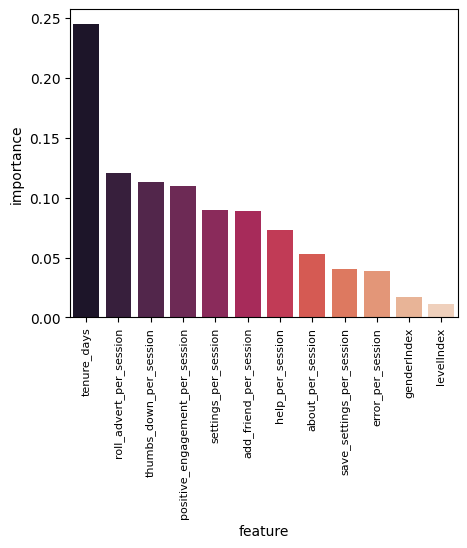

In [71]:
# visualize feature importance
fig = plt.figure(figsize=(5, 4))
sns.barplot(x='feature', y='importance', palette='rocket',data=feature_importance_df);
plt.xticks(rotation=90,fontsize=8);

**NOTE**: 

By performing hyperparameter tuning, we acheived slightly improvement in f-1 scores for validation and test sets using random forest classifier. The limit of performance improvement might be due to the fact that the data set is imbalanced (99 churned vs 349 unchurned unqiue users). Even we use f-1 score as metric to reduce the bias from imbalanced data, rebalancing could be performed to further improve model performance.

Looking at feature importance ranking, we could see that customer tenure time is the most important, followed by user actions, such as reciving ads, thumb-downs, and positive engagements (add to playlist, nextsong, thumbs up). On the other side of the spectrum, gender and level of service are of least importance, which is in line with the hypothesis testing where the difference is not significant.